In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick


In [3]:
df = pd.read_csv(params.final_csv, index_col=0, parse_dates=True)
df

open      high      low     close    atr_14  \
2014-04-03 08:49:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:50:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:51:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:52:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:53:00   28.650   28.6500   28.650   28.6500  0.000000   
...                      ...       ...      ...       ...       ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650  0.304529   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800  0.317029   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100  0.323814   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  0.322743   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  0.374521   

                         vwap_dev       ma_20  macd_12_26           obv  hour  \
2014-04-03 08:49:00  1.240040e-16   28.650000    0.000000  0.000000e+00     8   
2014-04-03 08:50:00  1.240040e-16   28.650000    0.000000  0.000000e+00     8   
2014-04-03 08:51:00  1.240040e-16   28.650000    0.000000  0.000000e+00     8   
2014-04-03 08:52:00  1.240040e-16   28.650000    0.000000  0.000000e+00     8   
2014-04-03 08:53:00  1.240040e-16   28.650000    0.000000  0.000000e+00     8   
...                           ...         ...         ...           ...   ...   
2025-06-18 20:56:00  1.257638e+00  174.838390   -0.422065  4.758230e+08    20   
2025-06-18 20:57:00  1.255215e+00  174.736890   -0.466939  4.751988e+08    20   
2025-06-18 20:58:00  1.254293e+00  174.634390   -0.502359  4.747443e+08    20   
2025-06-18 20:59:00  1.253874e+00  174.527890   -0.526778  4.736496e+08    20   
2025-06-18 21:00:00  1.257962e+00  174.442375   -0.513606  4.812994e+08    21   

                     month         bid         ask  signal_smooth  
2014-04-03 08:49:00      4   28.641405   28.658595       0.219822  
2014-04-03 08:50:00      4   28.641405   28.658595       0.220376  
2014-04-03 08:51:00      4   28.641405   28.658595       0.220931  
2014-04-03 08:52:00      4   28.641405   28.658595       0.221487  
2014-04-03 08:53:00      4   28.641405   28.658595       0.222044  
...                    ...         ...         ...            ...  
2025-06-18 20:56:00      6  173.512900  173.617100       0.002995  
2025-06-18 20:57:00      6  173.328000  173.432000       0.002906  
2025-06-18 20:58:00      6  173.258000  173.362000       0.005611  
2025-06-18 20:59:00      6  173.228000  173.332000       0.006685  
2025-06-18 21:00:00      6  173.557600  173.661800       0.003506  

[2117801 rows x 14 columns]

{'ATT_DROPOUT': 0.3,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.35,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 10,
 'ETA_MIN': 2e-05,
 'INITIAL_LR': 0.0007,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 64,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


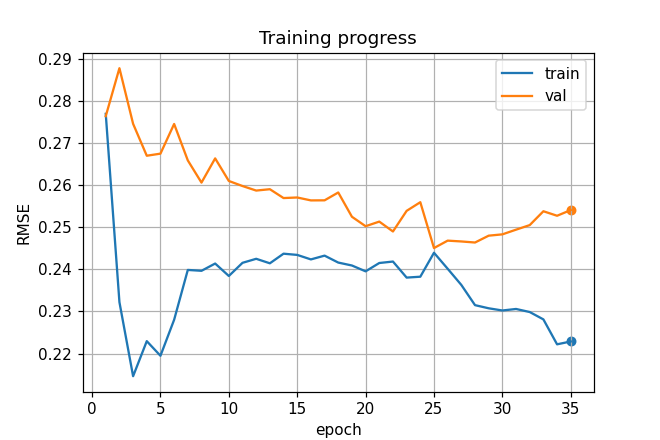

DualMemoryLSTM(
  (short_lstm): LSTM(11, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.22954890576005055, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 128, batch_first=True)
  (do_long): Dropout(p=0.343468190413778, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1132845, val=236394, te=240962
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.51801
Test zero‐forecast baseline RMSE = 0.55302


std val: 0.32973263
std test: 0.34039408


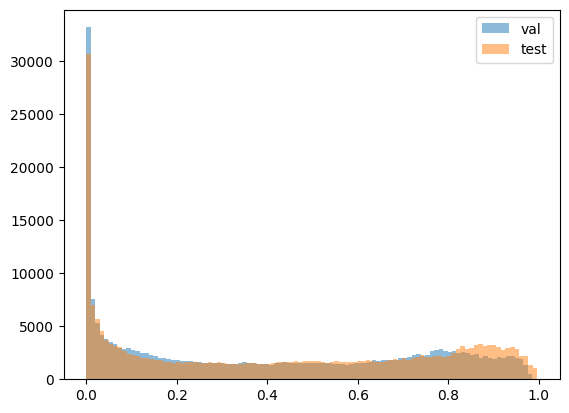

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching  val‐phase logic:

    • Expects each batch from `loader` to be a tuple of at least
      (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
    • xb_batch: Tensor(B, W, look_back, F)
    • yb_batch: Tensor(B, W)
    • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
    """

    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # grab only the first three outputs, ignore raw_close/raw_bid/etc.
            xb_batch, yb_batch, day_id_batch = batch[:3]

            # move to device once
            xb_batch     = xb_batch.to(device, non_blocking=True)
            yb_batch     = yb_batch.to(device, non_blocking=True)
            day_id_batch = day_id_batch.to(device, non_blocking=True)

            # if we got one day_id per window, reduce to one/day
            if day_id_batch.dim() > 1:
                day_id_batch = day_id_batch[:, 0]

            B, W = xb_batch.shape[0], xb_batch.shape[1]

            for i in range(B):
                x_day  = xb_batch[i]             # (W, look_back, F)
                y_day  = yb_batch[i].view(-1)    # (W,)
                day_id = int(day_id_batch[i].item())

                # reset LSTM states exactly as in val loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)

    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds


In [9]:
# train_rmse, train_preds = evaluate_model(
#     model_best, train_loader, device,
#     split_name="Train"
# )
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

# print("Train preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Validation:   0%|          | 0/414 [00:00<?, ?batch/s]


Validation RMSE over 236394 windows = 0.25409


Test:   0%|          | 0/422 [00:00<?, ?batch/s]


Test RMSE over 240962 windows = 0.28541
Val   preds: 236394
Test  preds: 240962


In [10]:
def add_pred_actions(
    df: pd.DataFrame,
    preds: np.ndarray,
    day_id_te: np.ndarray,
    pred_threshold: float,
    trailing_stop_thresh: float
) -> pd.DataFrame:
    """
    Returns a full-day DataFrame augmented with
      - pred_signal (NaN outside test-window)
      - pred_action (integer: -1/0/+1 everywhere)
    so downstream sim & plotting see the full x-axis.
    """
    # 1) Copy & init columns
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0  # default: no trade

    # 2) Identify test‐days by index normalize & map via day_id_te
    all_days = sorted(df_out.index.normalize().unique())
    test_ids = np.unique(day_id_te).astype(int)
    test_days = [all_days[i] for i in test_ids]

    # 3) Build mask of all post-start rows on test days
    mask = (
        df_out.index.normalize().isin(test_days)
        & (df_out.index.time >= regular_start_pred) 
    )
    idx = df_out.loc[mask].index

    # 4) Stamp your model’s predictions on those valid slots
    if len(idx) != len(preds):
        raise ValueError(
            f"Expected {len(idx)} prediction slots, got {len(preds)} preds"
        )
    df_out.loc[idx, "pred_signal"] = preds

    # 5) Generate & write back integer actions per test day
    for day in test_days:
        # slice just that day
        day_slice = df_out[df_out.index.normalize() == day]

        # generate_trade_actions expects pred_signal + writes pred_action
        day_actions = trades.generate_trade_actions(
            df                   = day_slice,
            col_signal           = "pred_signal",
            col_action           = "pred_action",
            buy_threshold        = pred_threshold,
            trailing_stop_thresh = trailing_stop_thresh,
            regular_start        = params.regular_start
        )

        # overwrite int actions only on real trade timestamps
        df_out.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"]
            .fillna(0)
            .astype(int)
        )

    # 6) Save & split back out
    df_out.to_csv(params.pred_csv)

    return df_out.loc[idx]


In [11]:
df_test = add_pred_actions(
                        df=df, 
                        preds=test_preds, 
                        day_id_te=day_id_te, 
                        pred_threshold=pred_threshold,
                        trailing_stop_thresh=trailing_stop_thresh 
                        )

df_test

open      high      low     close    atr_14  vwap_dev  \
2023-10-12 11:30:00  141.620  141.6300  141.600  141.6000  0.065714  1.181458   
2023-10-12 11:31:00  141.620  141.7100  141.600  141.7100  0.072857  1.183153   
2023-10-12 11:32:00  141.610  141.6500  141.610  141.6500  0.072143  1.182229   
2023-10-12 11:33:00  141.650  141.6500  141.560  141.5800  0.073571  1.181150   
2023-10-12 11:34:00  141.580  141.5800  141.540  141.5500  0.076429  1.180688   
...                      ...       ...      ...       ...       ...       ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650  0.304529  1.257638   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800  0.317029  1.255215   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100  0.323814  1.254293   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  0.322743  1.253874   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  0.374521  1.257962   

                          ma_20  macd_12_26           obv  hour  month  \
2023-10-12 11:30:00  141.438000    0.100816  4.793747e+08    11     10   
2023-10-12 11:31:00  141.461500    0.106901  4.793758e+08    11     10   
2023-10-12 11:32:00  141.480500    0.105663  4.793745e+08    11     10   
2023-10-12 11:33:00  141.495500    0.097906  4.793743e+08    11     10   
2023-10-12 11:34:00  141.509000    0.088319  4.793741e+08    11     10   
...                         ...         ...           ...   ...    ...   
2025-06-18 20:56:00  174.838390   -0.422065  4.758230e+08    20      6   
2025-06-18 20:57:00  174.736890   -0.466939  4.751988e+08    20      6   
2025-06-18 20:58:00  174.634390   -0.502359  4.747443e+08    20      6   
2025-06-18 20:59:00  174.527890   -0.526778  4.736496e+08    20      6   
2025-06-18 21:00:00  174.442375   -0.513606  4.812994e+08    21      6   

                          bid       ask  signal_smooth  pred_signal  \
2023-10-12 11:30:00  141.5575  141.6425       0.069690     0.218220   
2023-10-12 11:31:00  141.6675  141.7525       0.034898     0.202927   
2023-10-12 11:32:00  141.6075  141.6925       0.000000     0.188806   
2023-10-12 11:33:00  141.5375  141.6225       0.000000     0.181114   
2023-10-12 11:34:00  141.5075  141.5925       0.000000     0.177929   
...                       ...       ...            ...          ...   
2025-06-18 20:56:00  173.5129  173.6171       0.002995     0.249447   
2025-06-18 20:57:00  173.3280  173.4320       0.002906     0.280423   
2025-06-18 20:58:00  173.2580  173.3620       0.005611     0.310423   
2025-06-18 20:59:00  173.2280  173.3320       0.006685     0.335759   
2025-06-18 21:00:00  173.5576  173.6618       0.003506     0.350551   

                     pred_action  
2023-10-12 11:30:00            0  
2023-10-12 11:31:00            0  
2023-10-12 11:32:00            0  
2023-10-12 11:33:00            0  
2023-10-12 11:34:00            0  
...                          ...  
2025-06-18 20:56:00            0  
2025-06-18 20:57:00            0  
2025-06-18 20:58:00            0  
2025-06-18 20:59:00            0  
2025-06-18 21:00:00           -1  

[240962 rows x 16 columns]

In [12]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal_smooth','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal_smooth'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

                  count      mean       std      min       25%       50%  \
signal_smooth  240962.0  0.435842  0.340395  0.00000  0.076693  0.429842   
pred_signal    240962.0  0.343646  0.157180  0.13622  0.215432  0.282609   

                    75%       max     range  pearson_r_with_other  
signal_smooth  0.768205  0.996222  0.996222              0.631894  
pred_signal    0.441128  0.767089  0.630869              0.631894  


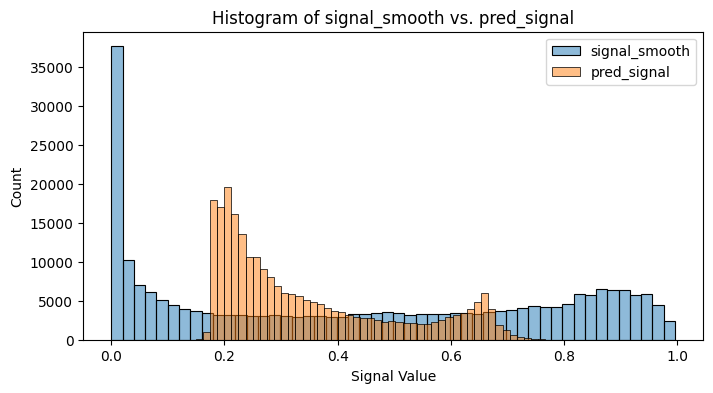

In [13]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal_smooth'], color='C0', alpha=0.5, bins=50, label='signal_smooth')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of signal_smooth vs. pred_signal')
plt.show()

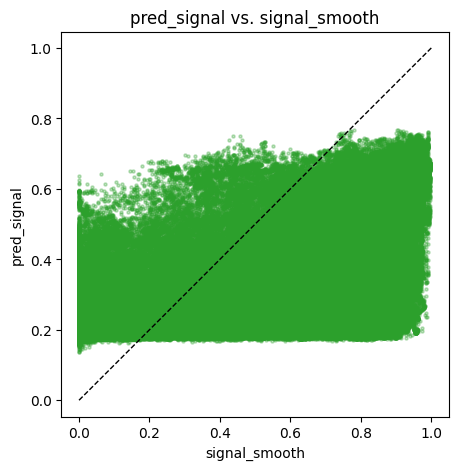

In [14]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal_smooth'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal_smooth')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal_smooth')
plt.axis('equal')
plt.show()

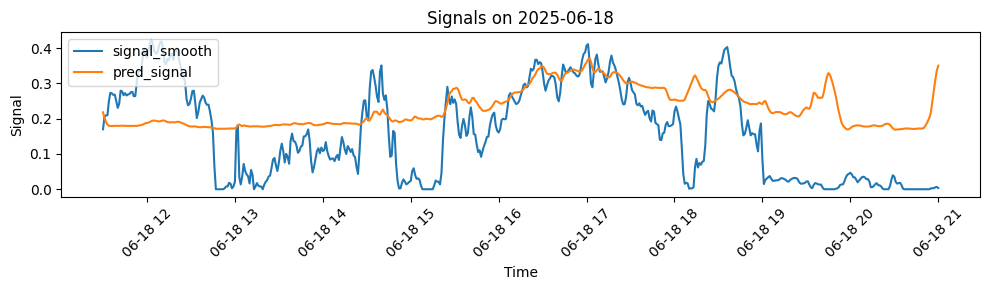

In [15]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal_smooth'], label='signal_smooth')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

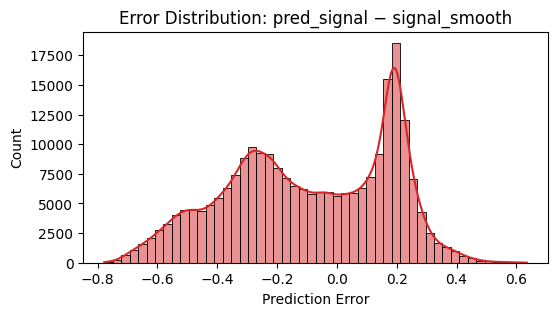

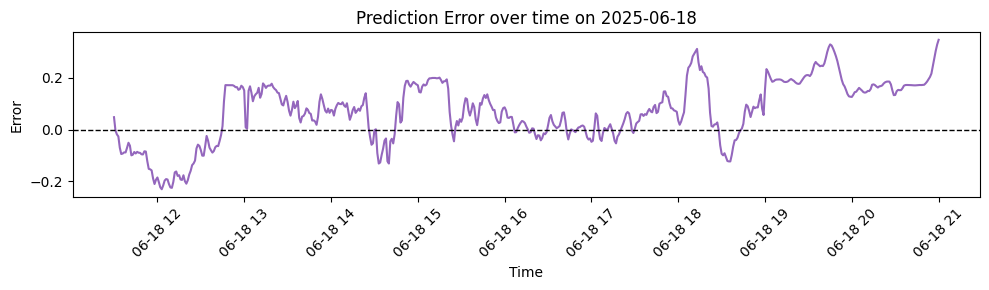

In [16]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal_smooth']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred_signal − signal_smooth')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_test,              # DF with pred_action
    col_action          = "pred_action",        # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2024-09:


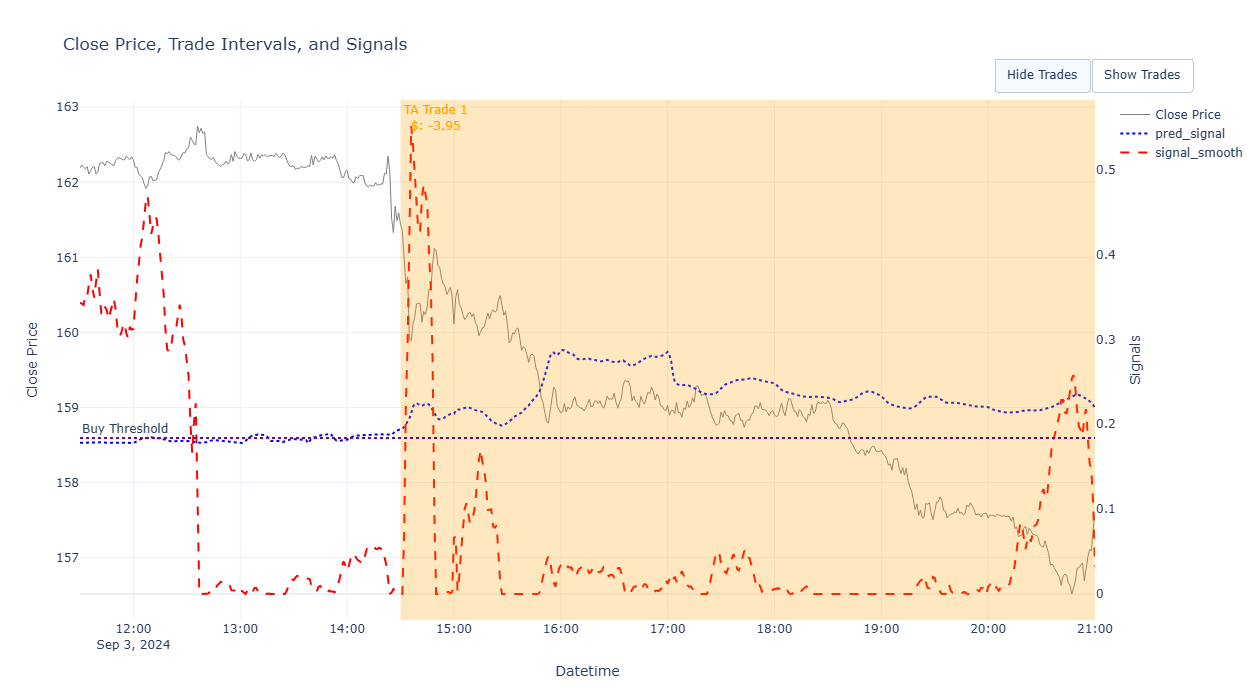


=== Performance for 2024-09-03 00:00:00 ===
Strategy Return ($): -4.146
Buy & Hold Return ($): -4.146
Trades Returns ($): [-3.95]


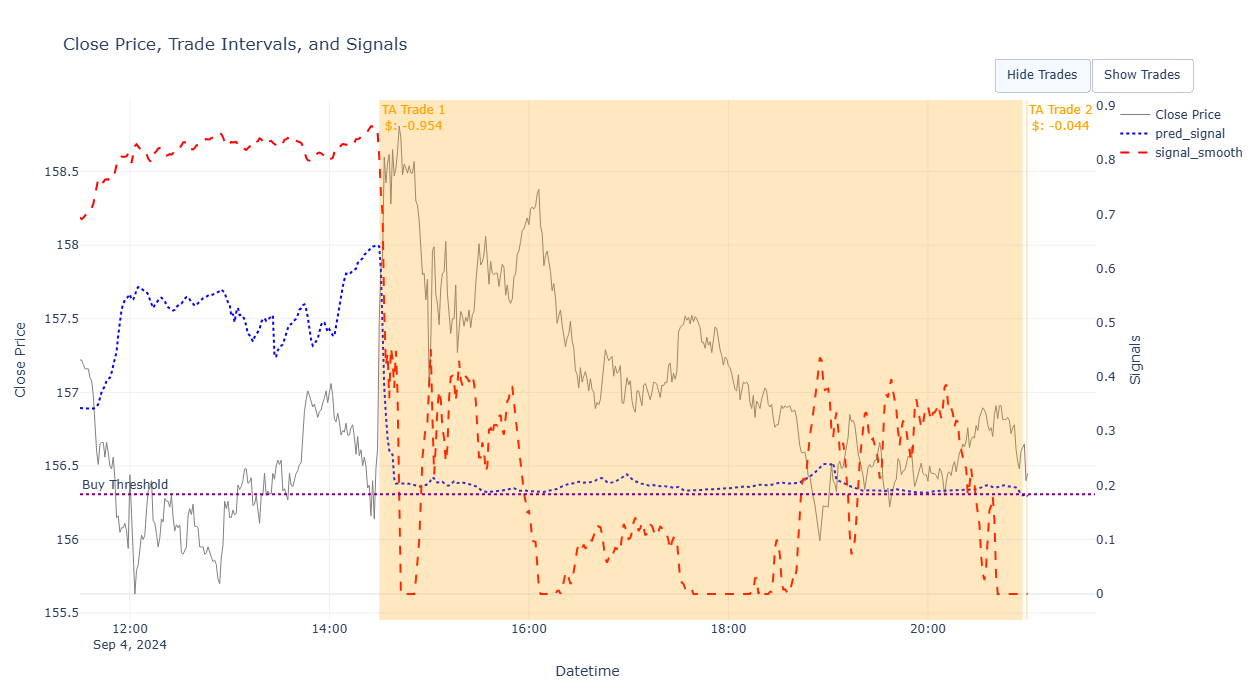


=== Performance for 2024-09-04 00:00:00 ===
Strategy Return ($): -1.048
Buy & Hold Return ($): -1.184
Trades Returns ($): [-0.954, -0.044]


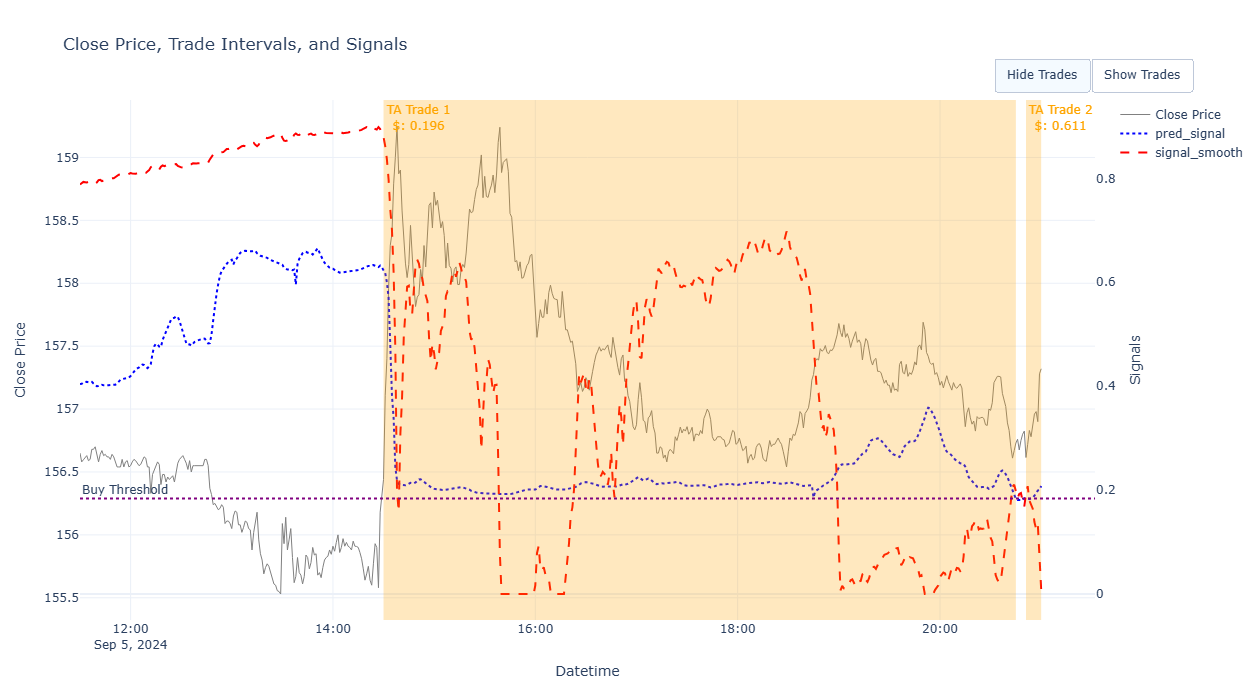


=== Performance for 2024-09-05 00:00:00 ===
Strategy Return ($): 0.767
Buy & Hold Return ($): 0.746
Trades Returns ($): [0.196, 0.611]


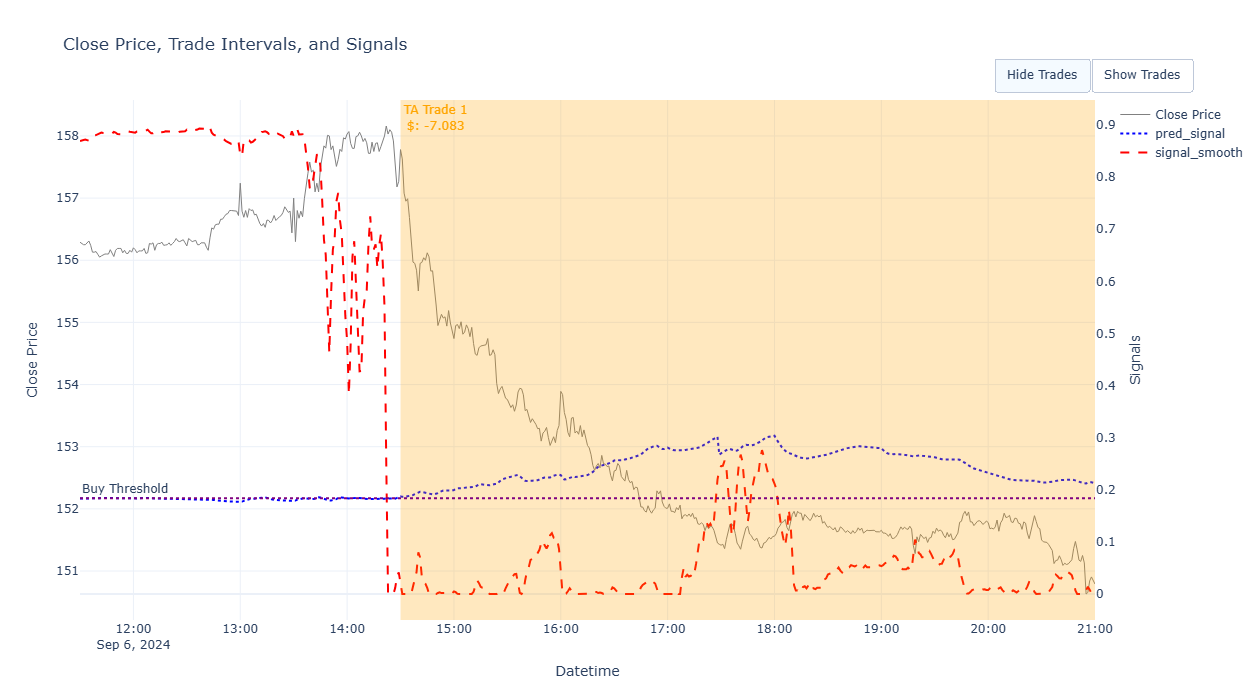


=== Performance for 2024-09-06 00:00:00 ===
Strategy Return ($): -7.023
Buy & Hold Return ($): -7.023
Trades Returns ($): [-7.083]


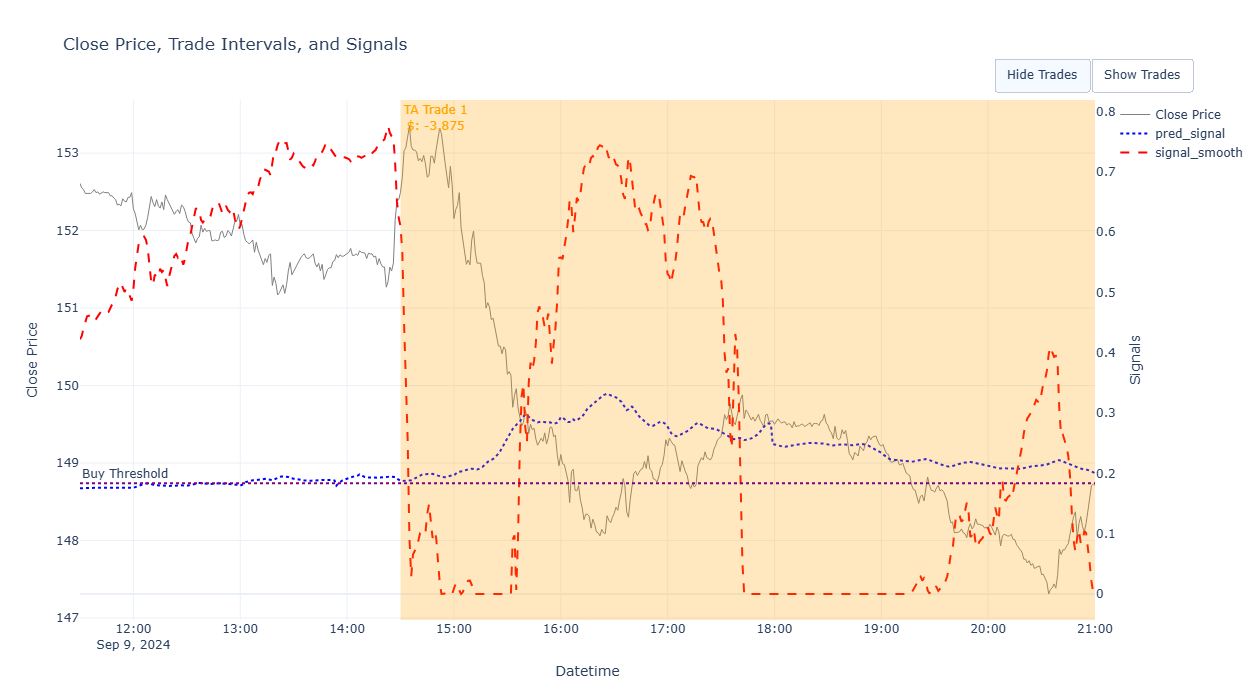


=== Performance for 2024-09-09 00:00:00 ===
Strategy Return ($): -3.855
Buy & Hold Return ($): -3.855
Trades Returns ($): [-3.875]


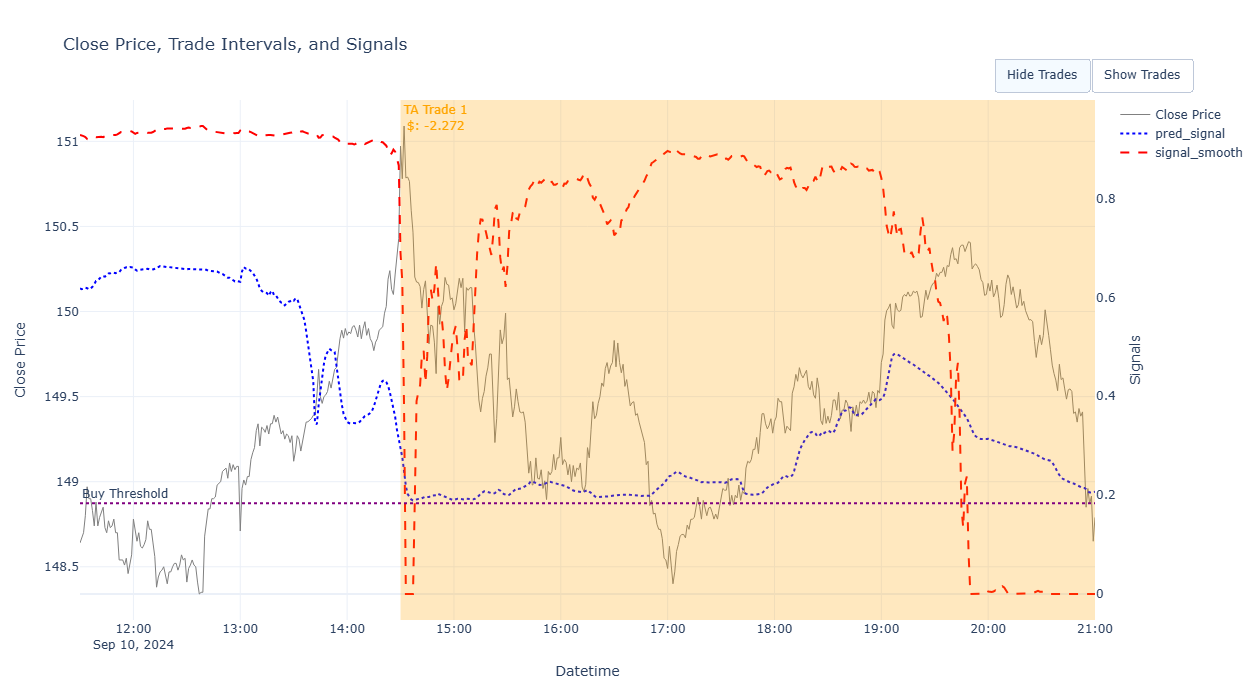


=== Performance for 2024-09-10 00:00:00 ===
Strategy Return ($): -2.412
Buy & Hold Return ($): -2.412
Trades Returns ($): [-2.272]


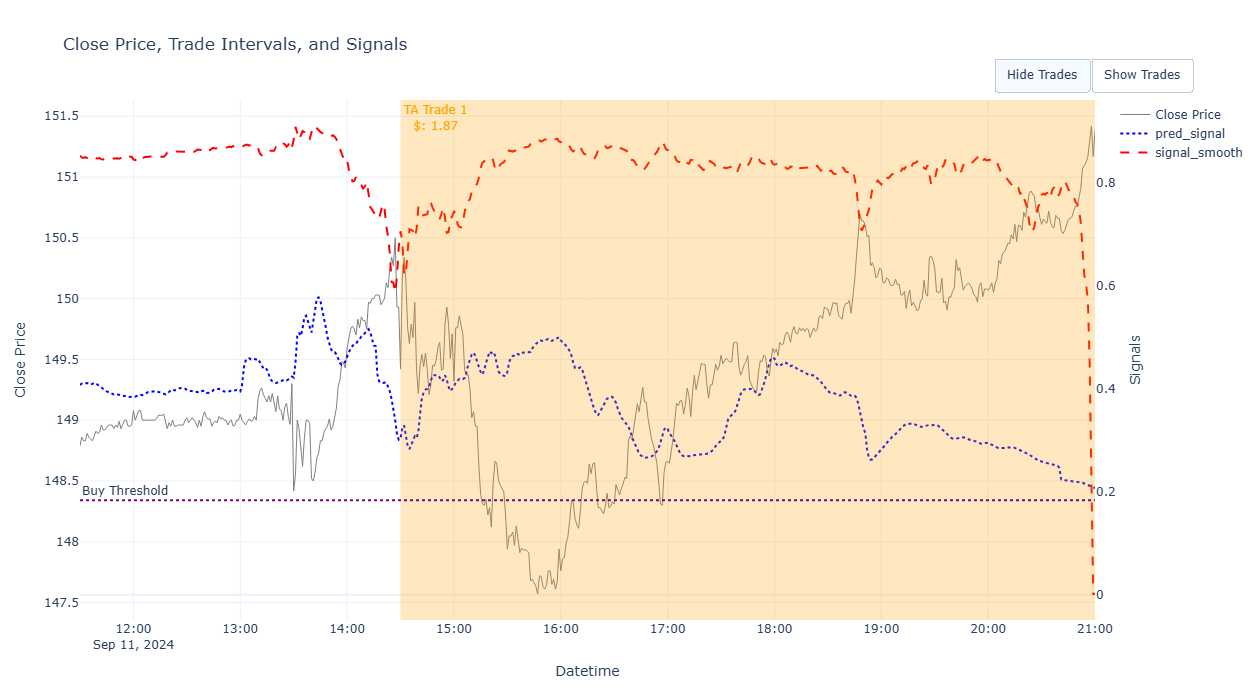


=== Performance for 2024-09-11 00:00:00 ===
Strategy Return ($): 1.66
Buy & Hold Return ($): 1.66
Trades Returns ($): [1.87]


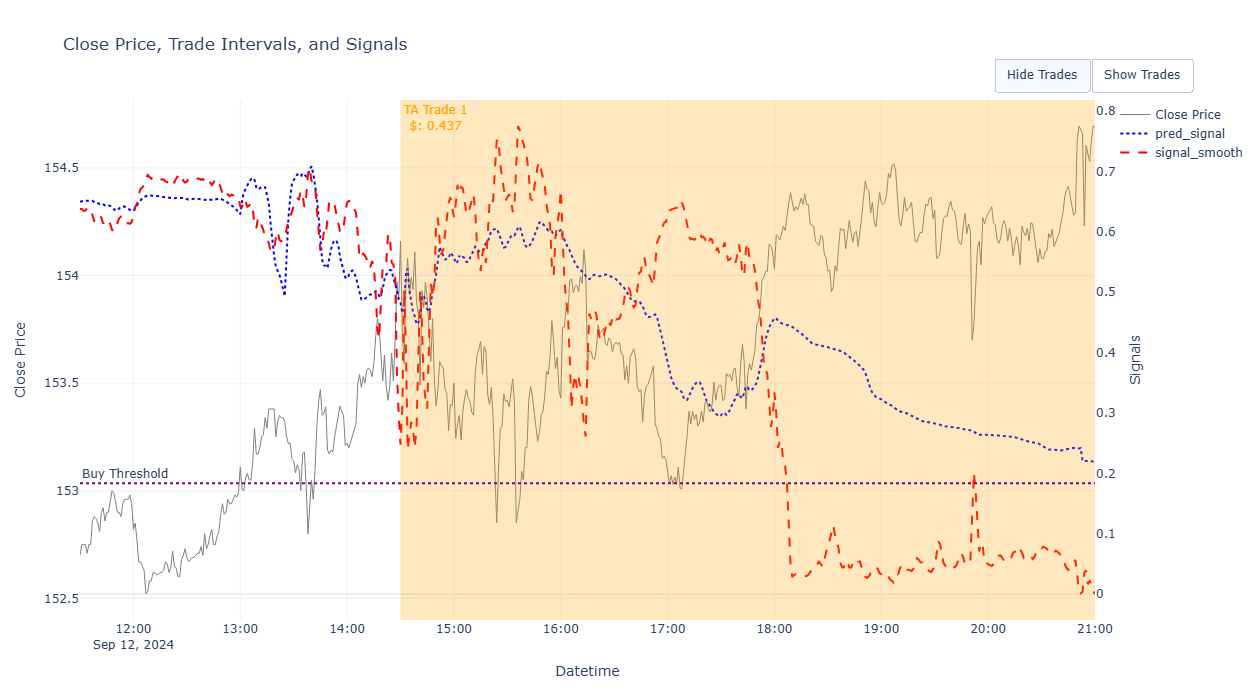


=== Performance for 2024-09-12 00:00:00 ===
Strategy Return ($): 0.442
Buy & Hold Return ($): 0.442
Trades Returns ($): [0.437]


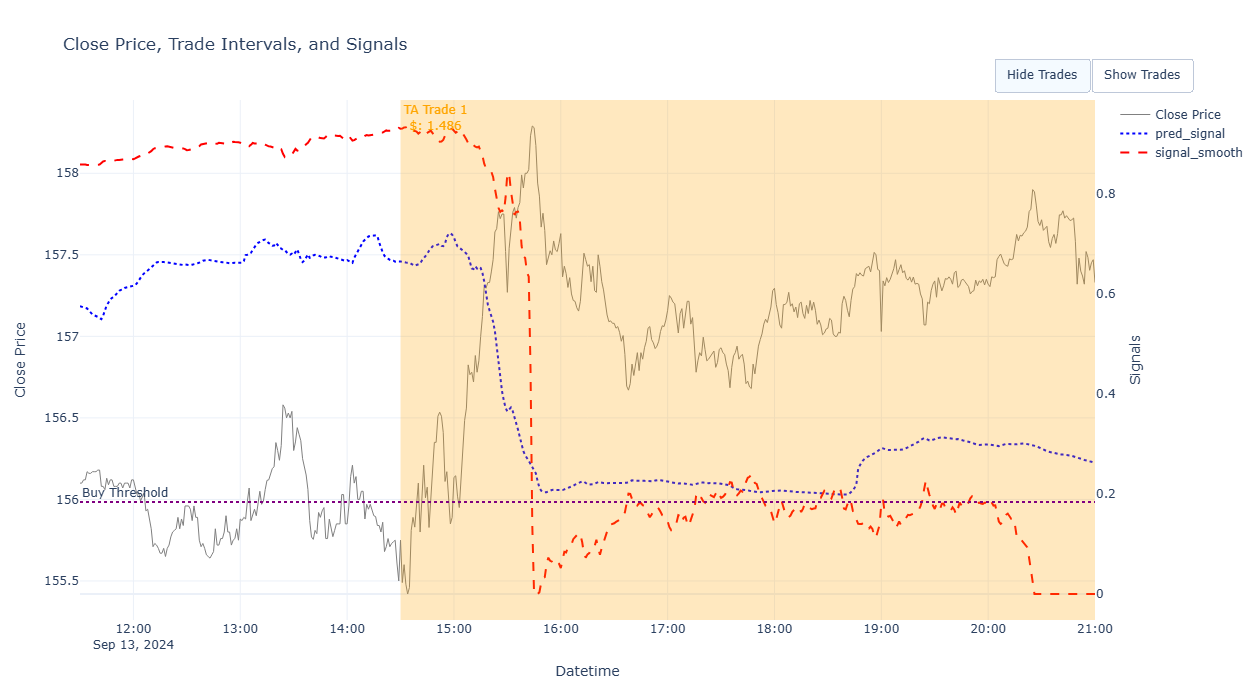


=== Performance for 2024-09-13 00:00:00 ===
Strategy Return ($): 1.626
Buy & Hold Return ($): 1.626
Trades Returns ($): [1.486]


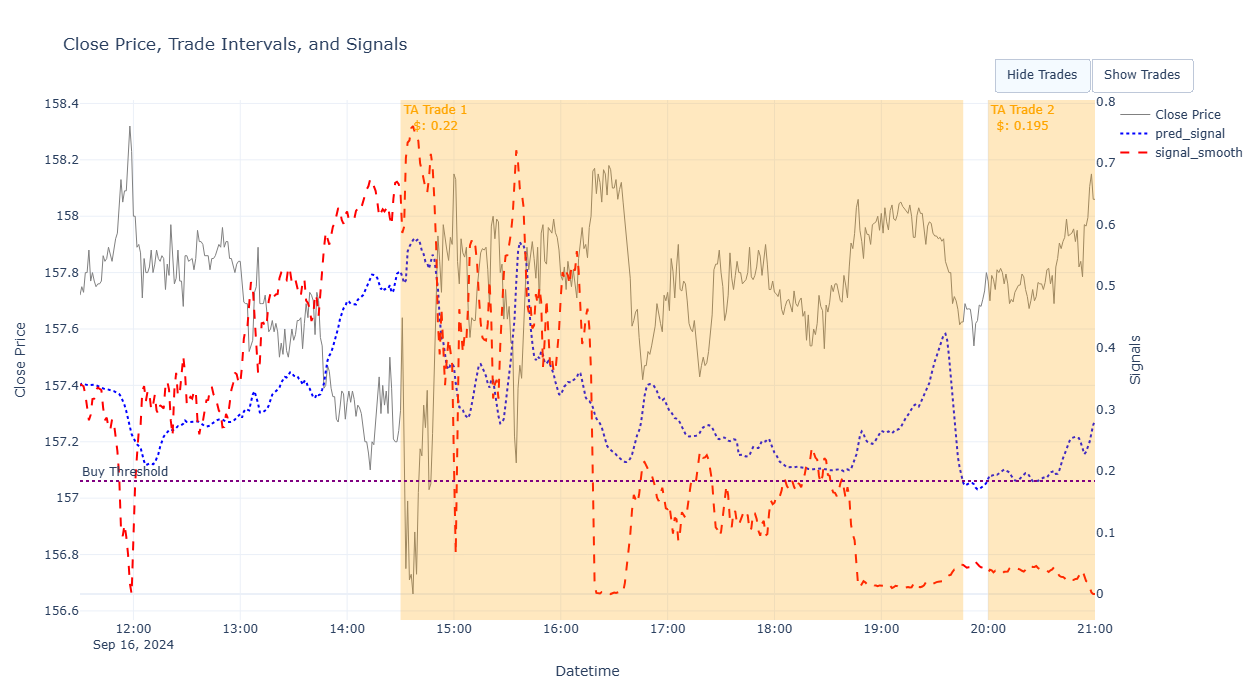


=== Performance for 2024-09-16 00:00:00 ===
Strategy Return ($): 0.416
Buy & Hold Return ($): 0.655
Trades Returns ($): [0.22, 0.195]


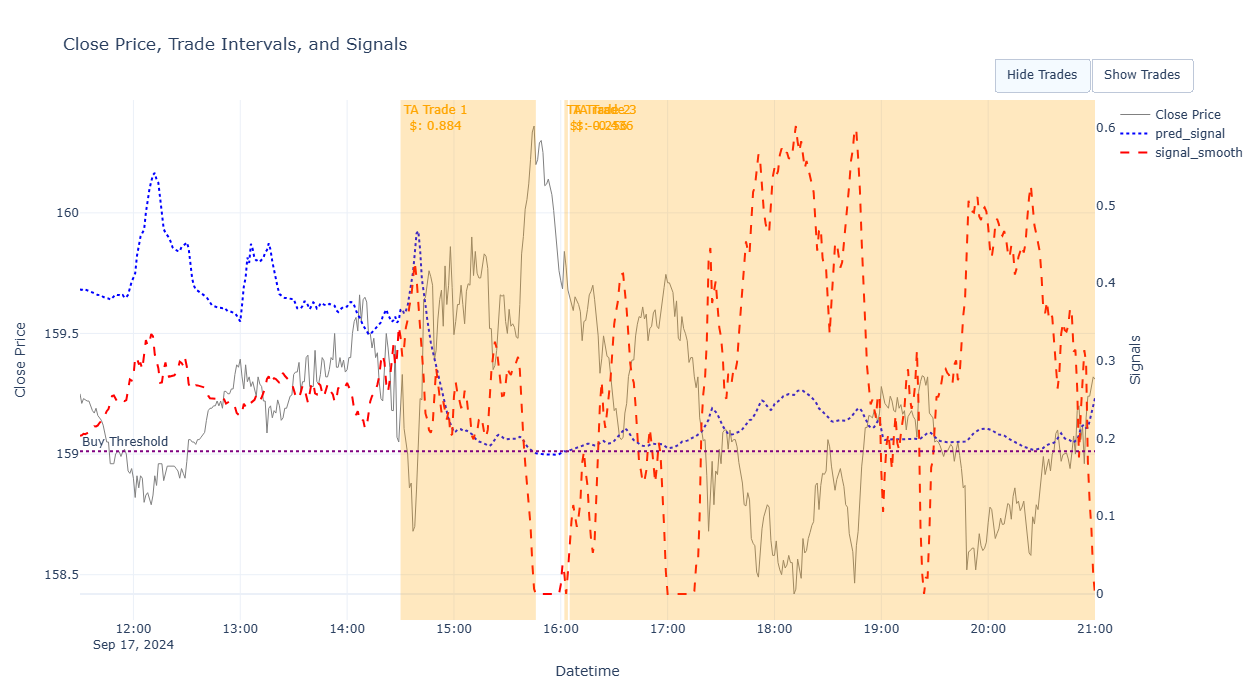


=== Performance for 2024-09-17 00:00:00 ===
Strategy Return ($): 0.203
Buy & Hold Return ($): 0.004
Trades Returns ($): [0.884, -0.256, -0.436]


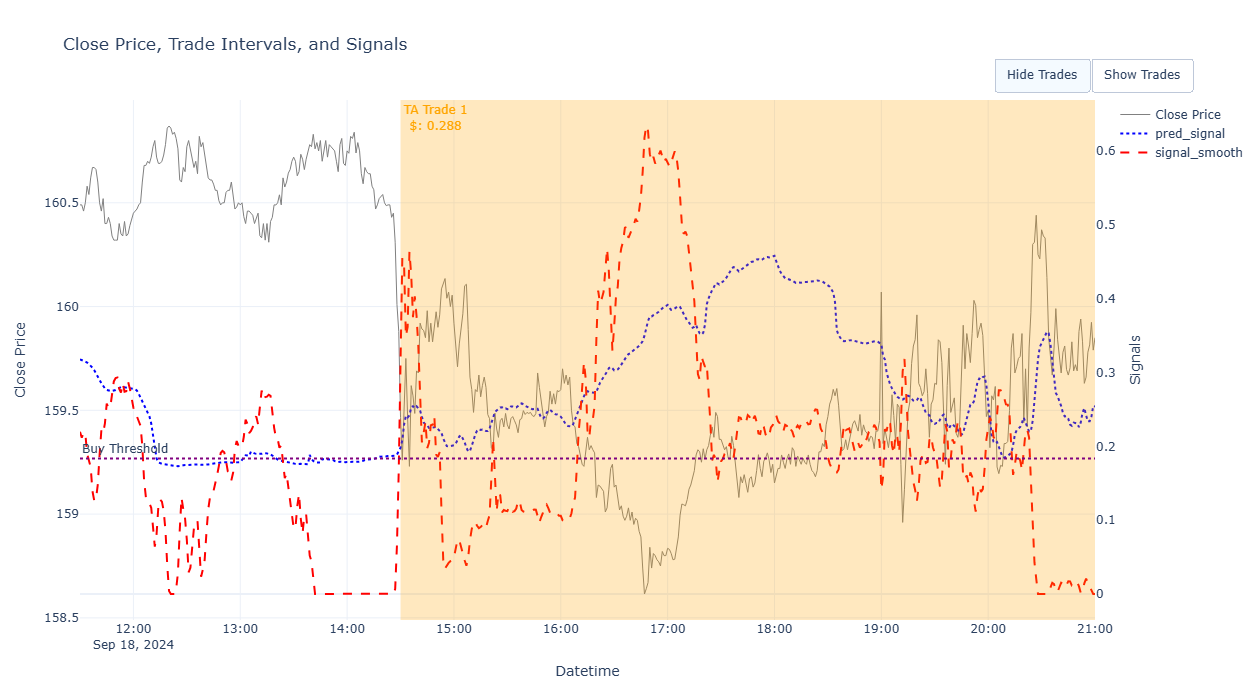


=== Performance for 2024-09-18 00:00:00 ===
Strategy Return ($): 0.228
Buy & Hold Return ($): 0.228
Trades Returns ($): [0.288]


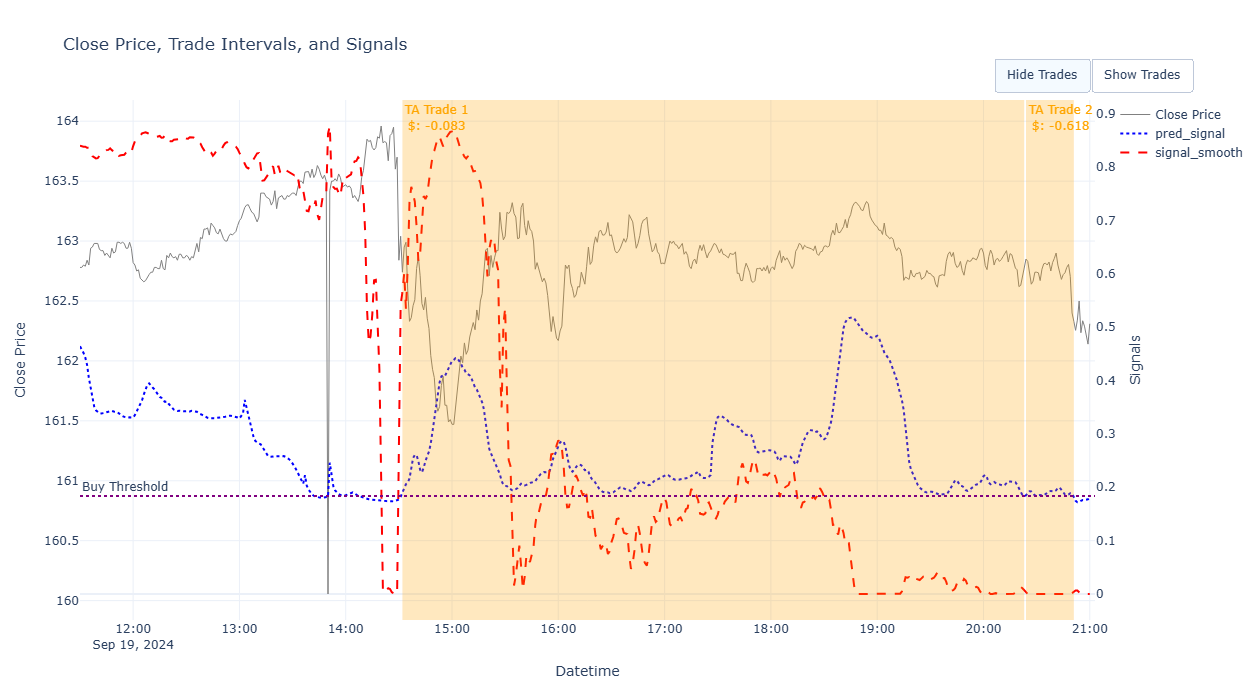


=== Performance for 2024-09-19 00:00:00 ===
Strategy Return ($): -0.7
Buy & Hold Return ($): -0.798
Trades Returns ($): [-0.083, -0.618]


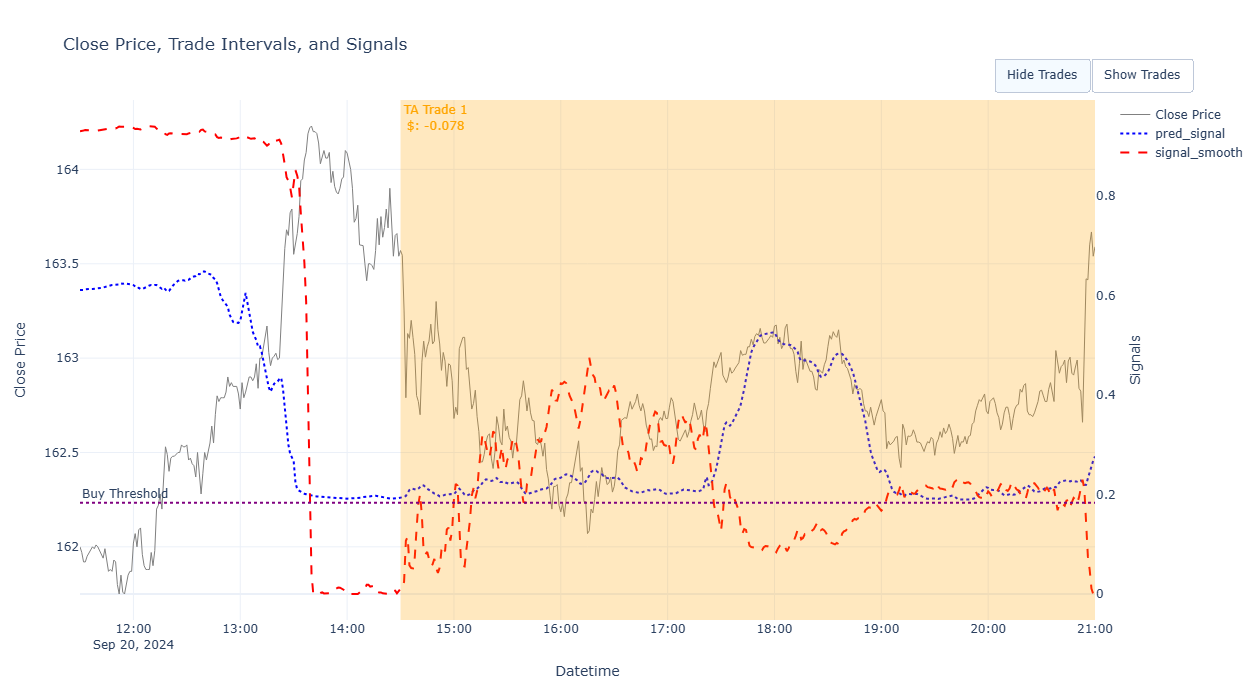


=== Performance for 2024-09-20 00:00:00 ===
Strategy Return ($): -0.128
Buy & Hold Return ($): -0.128
Trades Returns ($): [-0.078]


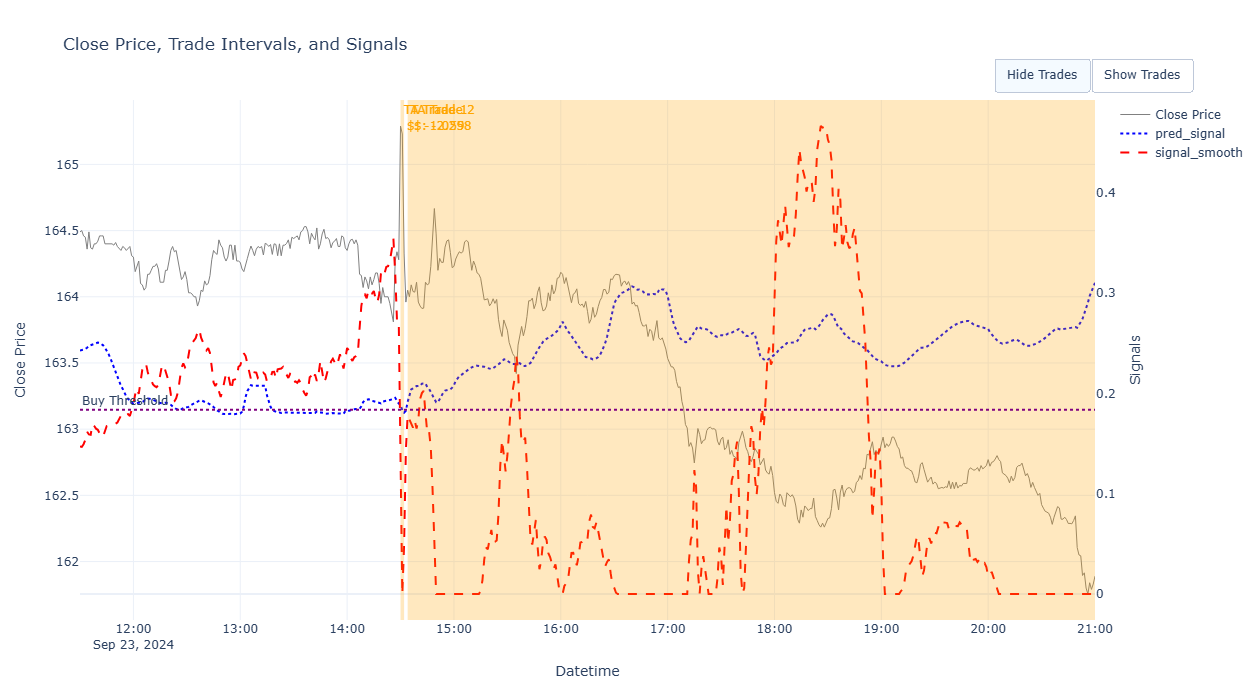


=== Performance for 2024-09-23 00:00:00 ===
Strategy Return ($): -3.377
Buy & Hold Return ($): -3.558
Trades Returns ($): [-1.059, -2.258]


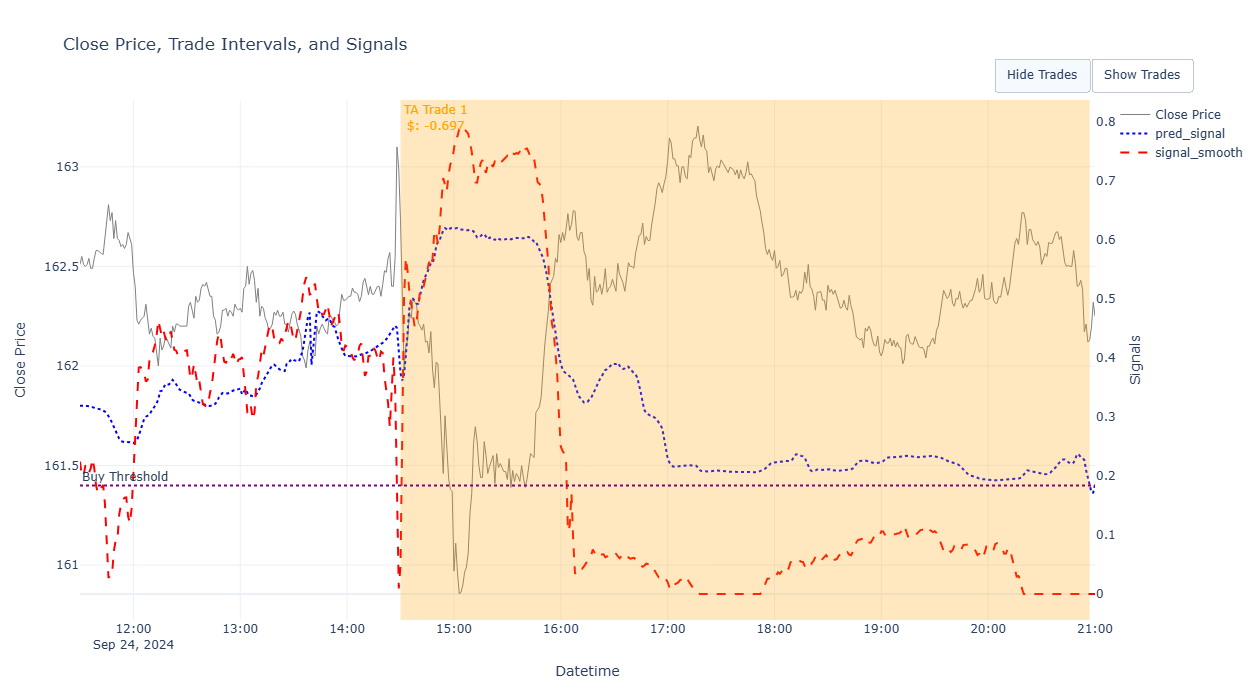


=== Performance for 2024-09-24 00:00:00 ===
Strategy Return ($): -0.697
Buy & Hold Return ($): -0.507
Trades Returns ($): [-0.697]


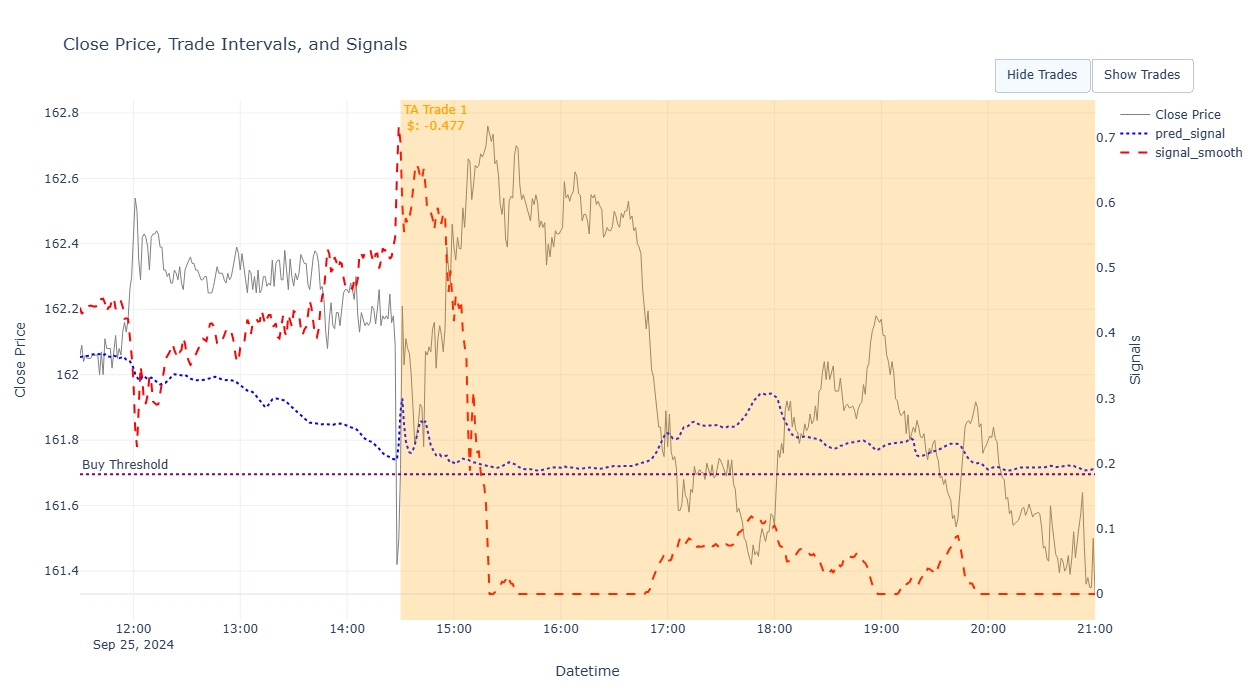


=== Performance for 2024-09-25 00:00:00 ===
Strategy Return ($): -0.307
Buy & Hold Return ($): -0.307
Trades Returns ($): [-0.477]


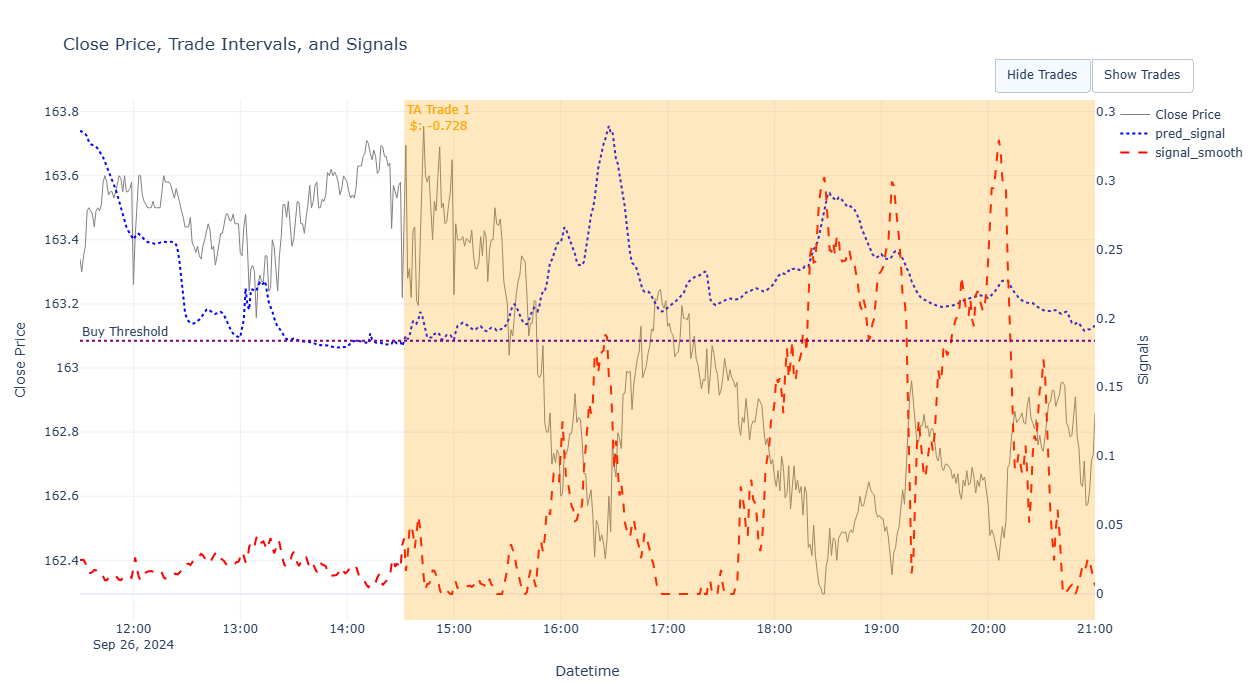


=== Performance for 2024-09-26 00:00:00 ===
Strategy Return ($): -0.858
Buy & Hold Return ($): -0.948
Trades Returns ($): [-0.728]


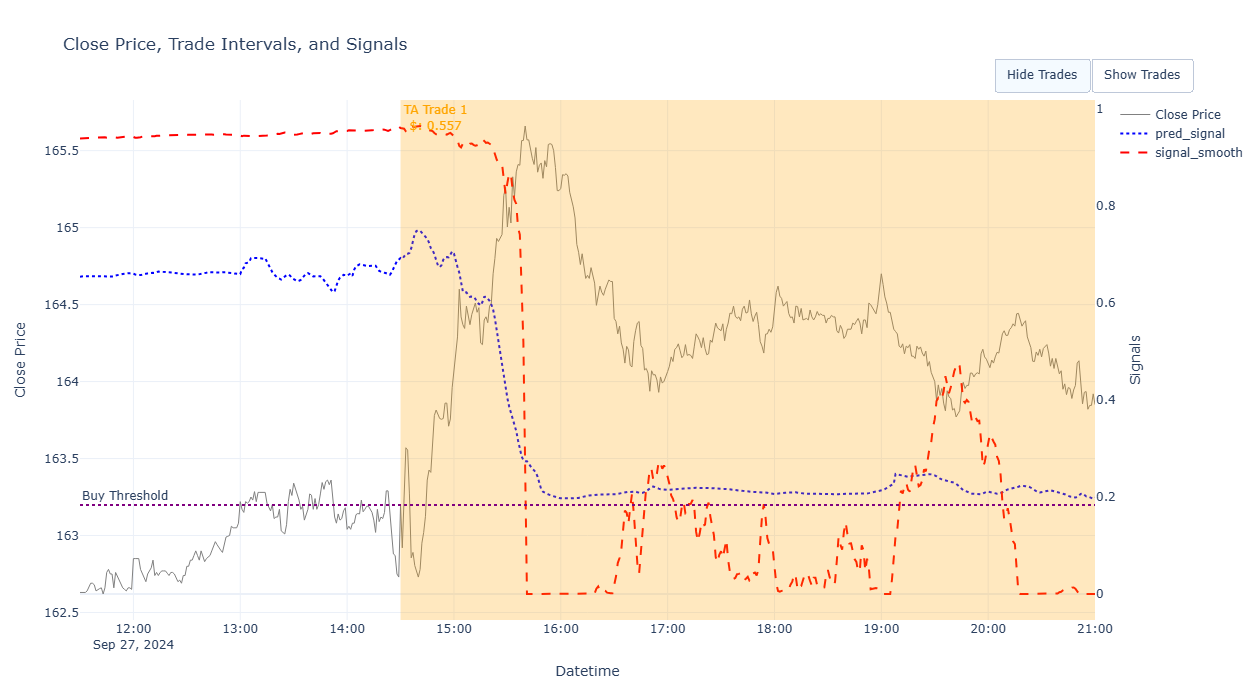


=== Performance for 2024-09-27 00:00:00 ===
Strategy Return ($): 0.627
Buy & Hold Return ($): 0.627
Trades Returns ($): [0.557]


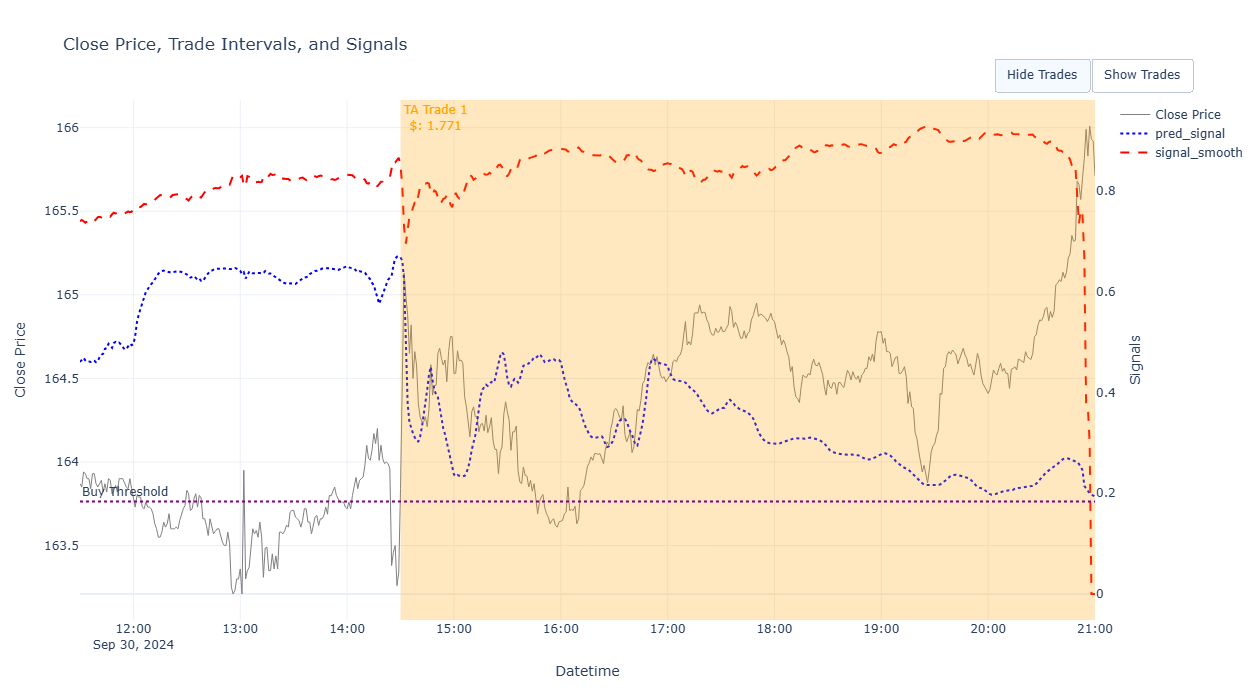


=== Performance for 2024-09-30 00:00:00 ===
Strategy Return ($): 1.981
Buy & Hold Return ($): 1.981
Trades Returns ($): [1.771]

=== Overall Summary (2024-09-03 → 2024-09-30) ===
Start date price: 2024-09-03 = 161.4884
  End date price:  2024-09-30 = 165.6603
One-time buy&hold gain: 4.172

{'Buy & Hold – each day ($)': -16.897,
 'Strategy Return ($)': -16.601,
 'Trades Returns ($)': '27 trades'}

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 140.4855
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 33.072

{'Buy & Hold – each day ($)': -77.566,
 'Strategy Return ($)': -54.201,
 'Trades Returns ($)': '597 trades'}


In [18]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_test)
pprint(overall_summary)
